In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.24/06


In [2]:
def readNumEvents(file):
    """
    Moderately efficent way to get the number of events stored in file.
    """
    
    with pylhe._extract_fileobj(file) as fileobj:
        nevts = sum(element.tag == "event" for event, element in ET.iterparse(fileobj, events=["end"]))
    return nevts

# Set LHE output files

In [3]:
inputFiles = {'noBias' : '../testCuts_LO_1j/Events/run_01/unweighted_events.lhe.gz'}

In [4]:
events = {}
nevents = {}
for label,f in inputFiles.items():   
    events[label] = pylhe.read_lhe_with_attributes(f)
    nevents[label] = readNumEvents(f)

# Load Model Parameters

In [5]:
parameters = {}
for label,file in inputFiles.items():
    banner = sorted(glob.glob(os.path.dirname(file)+'/*banner.txt'),key=os.path.getmtime,reverse=True)
    if len(banner) == 0:
        print('Banner not found for %s' %label)
    elif len(banner) > 1:        
        print('\n%i banner files found for %s. Using %s' 
              %(len(banner),label,os.path.basename(banner[0])))
    banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    mMed = pars.blocks['MASS'][55]
    mDM = pars.blocks['MASS'][52]
    gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
    gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
    gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
    gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    parameters[label] = {'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV' %(mMed,mDM))

noBias : mMed = 2000.00 GeV, mDM = 1.00 GeV


# Load events, apply cuts and store relevant info

## Cuts

In [6]:
## jets
pTj1min = 100.
pTjmin = 25.
etamax = 2.4
## MET
minMET = 250.
## Electrons
pTmin_el = 10.
etamax_el = 2.5
nMax_el = 0
## Muons
pTmin_mu = 10.
etamax_mu = 2.4
nMax_mu = 0


In [8]:
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
njets = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0 for label in inputFiles}

for label,evts in events.items():
   
    nevts = nevents[label]
    parameters[label]['Events'] = nevts
    
    for event in evts:

        particles = event.particles
       
        jets = [p for p in particles if abs(p.id) in [1,2,3,4,5,21] and p.status == 1]
        dm = [p for p in particles if abs(p.id) in [52] and p.status == 1]
        electrons = [p for p in particles if abs(p.id) in [11] and p.status == 1]
        muons = [p for p in particles if abs(p.id) in [13] and p.status == 1]
        
        if len(dm) != 2:
            continue
            
            
        weight = event.eventinfo.weight/nevts
        totalweight[label] += weight
            
        # Filter jets
        jetList = []
        for j in jets:
            pT = np.sqrt(j.px**2+j.py**2)
            p = np.sqrt(j.px**2+j.py**2+j.pz**2)
            pL = j.pz
            eta = 0.5*np.log((p+pL)/(p-pL))
            
            if pT < pTjmin:
                continue
            if np.abs(eta) > etamax:
                continue
            jetList.append(j)
        jetList = sorted(jetList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)          
        
            
        # Filter electrons
        electronList = []
        for el in electrons:
            pT = np.sqrt(el.px**2+el.py**2)
            p = np.sqrt(el.px**2+el.py**2+el.pz**2)
            pL = el.pz
            eta = 0.5*np.log((p+pL)/(p-pL))
            
            if pT < pTmin_el:
                continue
            if np.abs(eta) > etamax_el:
                continue
            electronList.append(el)
        electronList = sorted(electronList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                    
        
        # Filter muons
        muonList = []
        for mu in muons:
            pT = np.sqrt(mu.px**2+mu.py**2)
            p = np.sqrt(mu.px**2+mu.py**2+mu.pz**2)
            pL = mu.pz
            eta = 0.5*np.log((p+pL)/(p-pL))
            
            if pT < pTmin_mu:
                continue
            if np.abs(eta) > etamax_mu:
                continue
            muonList.append(mu)
        muonList = sorted(muonList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                            
              
        # Compute MET
        MET = np.sqrt((dm[0].px+dm[1].px)**2 + (dm[0].py+dm[1].py)**2)
        
        
        # Store relevant data        
        njets[label] = np.append(njets[label],len(jets))
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],MET)


In [9]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb' %w)
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(weights.keys())}    

noBias total cross-section = 1.131e-01 pb


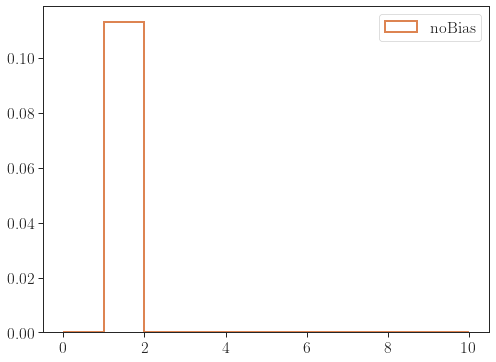

In [10]:
fig = plt.figure(figsize=(8,6))
for label,pt in njets.items():
    plt.hist(pt,bins=np.linspace(0,10,11),label=label,histtype='step',
             weights=weights[label],linewidth=2,color=colors[label])
# plt.yscale('log')
# plt.ylim(1e-5,1)
# plt.xlim(0,2000)
plt.legend()
plt.show()

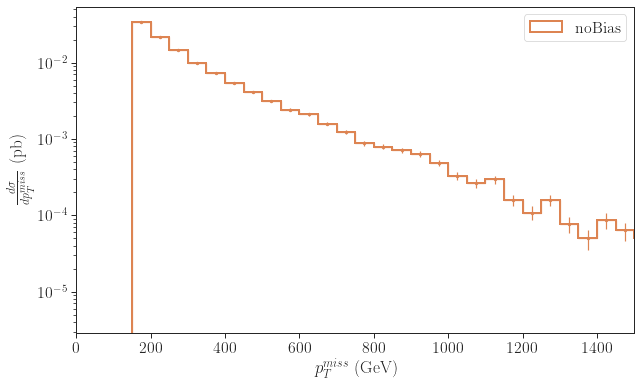

In [11]:
fig = plt.figure(figsize=(10,6))
for label,metPts in met.items():
    binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2)
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
    plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
                 drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-3,1)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(0,1500)
plt.legend()
plt.show()

In [12]:
print(metPts.min())

150.01266437867127


# Get official CMS data

In [ ]:
pickleFile = '../monoJet/CMS-EXO-20-004-data/Signaltemplates_DMsimp_spin-1_Monojet_DF.pcl'
df = pd.read_pickle(pickleFile)

### Filter model

In [ ]:
if gAx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Axial")]
elif gVx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Vector")]

if len(dfModel) != 1:
    print('%i data rows selected' %(len(dfModel)))

In [ ]:
bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if "bin_" in c}
cmsData = {c : dfModel[c].iloc[0] for c in bins}
rightBin = 2000.
binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()

# Plot CMS data
cmsValues = np.array(list(cmsData.values()))

## Plot Results

In [ ]:
lum2017 = 41.5 #fb^-1
kfactor = 1.2 # NLO (approx) k-factor
weightY = {label : w*1e3*lum2017*kfactor for label,w in weights.items()} # weights for the Yield


f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

for label,metPts in met.items():
#     if label != 'noBias': continue
    # Plot MC bins
    binc,binEdges,_= axarr[0].hist(metPts,bins=list(bins.values())+[rightBin],
                                   label=label,linewidth=2,
                                   weights=weightY[label],histtype='step',color=colors[label])
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weightY[label]**2)
    errorc = np.sqrt(errorc2)
    axarr[0].errorbar(binCenter,binc,yerr = errorc, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color=colors[label],linewidth=0.0)

    
    relDiff = (binc-cmsValues)/cmsValues
    ratio = binc/cmsValues
    relDiffErr = np.abs(binc-cmsValues)/errorc
    #Plot ratio
    axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label])
    
    
# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
axarr[0].scatter(x=binCenter,y=cmsValues,s=30,c='black')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')
axarr[0].set_ylim(0.5,3e2)


# axarr[1].axhline(y=1.)
axarr[1].set_ylim(0.0,3)
# axarr[1].set_yticks([0.25,0.5,0.75,1.0,1.25,1.5])
# axarr[1].set_yscale('log')
# axarr[1].set_ylabel('Relative Diff.', fontsize=18) #Y-label
axarr[1].set_ylabel(r'$\frac{\mbox{(CMS-Recast)}}{\mbox{MC Error}}$', fontsize=14) #Y-label
axarr[1].grid(True)
axarr[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')

#     axarr[0].set_title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f, k-factor = %1.2f' 
#               %(lum2017,list(cutFlow.values())[-1]/totalweight,kfactor))
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.5,2.3,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
axarr[0].legend()
axarr[0].set_title('k-factor = %1.2f' %kfactor)
plt.show()

In [ ]:
lum2017 = 41.5 #fb^-1
kfactor = 1.25 # NLO (approx) k-factor
weightY = {label : w*1e3*lum2017*kfactor for label,w in weights.items()} # weights for the Yield


f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

for label,metPts in met.items():
#     if label != 'noBias': continue
    # Plot MC bins
    binc,binEdges,_= axarr[0].hist(metPts,bins=list(bins.values())+[rightBin],
                                   label=label,linewidth=2,
                                   weights=weightY[label],histtype='step',color=colors[label])
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weightY[label]**2)
    errorc = np.sqrt(errorc2)
    axarr[0].errorbar(binCenter,binc,yerr = errorc, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color=colors[label],linewidth=0.0)

    
    relDiff = (binc-cmsValues)/cmsValues
    ratio = binc/cmsValues
    relDiffErr = np.abs(binc-cmsValues)/errorc
    #Plot ratio
#     axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label])
    axarr[1].plot(binCenter,relDiff,linewidth=3.0,color=colors[label])
    
    
# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
axarr[0].scatter(x=binCenter,y=cmsValues,s=30,c='black')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')
axarr[0].set_ylim(0.5,3e2)


# axarr[1].axhline(y=1.)
axarr[1].set_ylim(-0.5,1.5)
# axarr[1].set_yticks([0.25,0.5,0.75,1.0,1.25,1.5])
# axarr[1].set_yscale('log')
axarr[1].set_ylabel('Relative Diff.', fontsize=18) #Y-label
# axarr[1].set_ylabel(r'$\frac{\mbox{(CMS-Recast)}}{\mbox{MC Error}}$', fontsize=14) #Y-label
axarr[1].grid(True)
axarr[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')

#     axarr[0].set_title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f, k-factor = %1.2f' 
#               %(lum2017,list(cutFlow.values())[-1]/totalweight,kfactor))
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.5,2.3,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
axarr[0].legend()
axarr[0].set_title('k-factor = %1.2f' %kfactor)
plt.show()